# Assignment 2 - Human Value Detection

## Dependencies

In [34]:
#!pip install lightning
#!pip install torchmetrics
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install python-dotenv

In [35]:
# file management
import urllib.request
import os
from pathlib import Path

import dotenv

# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# torchmetrics
from torchmetrics import PrecisionRecallCurve
from torchmetrics.classification import MultilabelConfusionMatrix

# pytorch lightning
from lightning import LightningModule
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torchmetrics.classification import MultilabelF1Score
from torchmetrics import Metric
from torchmetrics import ConfusionMatrix

# transformers
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer

In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
#If torch deterministic gives problems, use this
#dotenv.load_dotenv("/content/drive/MyDrive/NLP/Assignments/A2/.env", override=True)
dotenv.load_dotenv("./.env", override=True)

True

## TASK 1: Corpus

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

### Download the corpus

In [38]:
# download data from url and save it to the data folder

file_names = [
    "arguments-training.tsv",
    "arguments-test.tsv",
    "arguments-validation.tsv",
    "labels-training.tsv",
    "labels-test.tsv",
    "labels-validation.tsv"
]

# Create the data folder
if not os.path.exists("./data"):
    os.makedirs("./data")

url = "https://zenodo.org/records/8248658/files/{file_name}?download=1"
for file_name in file_names:
    if os.path.exists(f"./data/{file_name}"):
        print(f"File {file_name} already exists. Skipping download...")
        continue

    file_url = url.format(file_name=file_name)
    print(f"Downloading {file_name} from {file_url}...")
    urllib.request.urlretrieve(url.format(file_name=file_name), f"./data/{file_name}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

File arguments-training.tsv already exists. Skipping download...
File arguments-test.tsv already exists. Skipping download...
File arguments-validation.tsv already exists. Skipping download...
File labels-training.tsv already exists. Skipping download...
File labels-test.tsv already exists. Skipping download...
File labels-validation.tsv already exists. Skipping download...


In [39]:
# Create the dataframes
df_arg_train = pd.read_csv('./data/arguments-training.tsv', sep='\t')
df_arg_test = pd.read_csv('./data/arguments-test.tsv', sep='\t')
df_arg_val = pd.read_csv('./data/arguments-validation.tsv', sep='\t')

df_labels_train = pd.read_csv('./data/labels-training.tsv', sep='\t')
df_labels_test = pd.read_csv('./data/labels-test.tsv', sep='\t')
df_labels_val = pd.read_csv('./data/labels-validation.tsv', sep='\t')

df_labels_test.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A26004,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,A26010,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2,A26016,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,A26024,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A26026,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0


### Annotations
Since the task requires only to take in account *level 3 categories* a mapping between *level 2* and *level 3* is created.

In [40]:
level_3_categories = ["Openness to change", "Self-enhancement", "Conservation", "Self-transcendence"]

level_3_to_2_mapping = {
    "Openness to change": [
        "Self-direction: thought",
        "Self-direction: action",
        "Stimulation",
        "Hedonism",
    ],
    "Self-enhancement": [
        "Hedonism",
        "Achievement",
        "Power: dominance",
        "Power: resources",
        "Face",
    ],
    "Conservation": [
        "Security: personal",
        "Security: societal",
        "Conformity: rules",
        "Conformity: interpersonal",
        "Tradition",
        "Face",
        "Humility",
    ],
    "Self-transcendence": [
        "Benevolence: caring",
        "Benevolence: dependability",
        "Universalism: concern",
        "Universalism: nature",
        "Universalism: tolerance",
        "Universalism: objectivity",
        "Humility",
    ]
}

column_to_drop = [level_2 for level_3 in level_3_to_2_mapping.values() for level_2 in level_3]

for category in level_3_categories:
    # make a logical OR of all the level 2 categories
    df_labels_test[category] = df_labels_test[level_3_to_2_mapping[category]].any(axis=1).map({True: 1, False: 0})
    df_labels_val[category] = df_labels_val[level_3_to_2_mapping[category]].any(axis=1).map({True: 1, False: 0})
    df_labels_train[category] = df_labels_train[level_3_to_2_mapping[category]].any(axis=1).map({True: 1, False: 0})

df_labels_test = df_labels_test.drop(columns=column_to_drop)
df_labels_val = df_labels_val.drop(columns=column_to_drop)
df_labels_train = df_labels_train.drop(columns=column_to_drop)

df_labels_test.head()

,Argument ID,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A26004,0,1,1,1
1,A26010,0,1,0,1
2,A26016,0,1,1,1
3,A26024,0,1,0,0
4,A26026,0,1,1,1


In [41]:
df_train = pd.merge(df_arg_train, df_labels_train, on='Argument ID')
df_test = pd.merge(df_arg_test, df_labels_test, on='Argument ID')
df_val = pd.merge(df_arg_val, df_labels_val, on='Argument ID')

df_train.head()

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


### Task 1.5 - stance encoding

In [42]:
# Encode stance into 0, 1
df_train["Stance"] = df_train["Stance"].map({"in favor of": 1, "against": 0})
df_test["Stance"] = df_test["Stance"].map({"in favor of": 1, "against": 0})
df_val["Stance"] = df_val["Stance"].map({"in favor of": 1, "against": 0})

df_train.head()

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,0,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,0,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,0,factory farming allows for the production of c...,0,0,1,1


### Dataset definition

In [43]:
class ArgumentDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "Premise": row["Premise"],
            "Conclusion": row["Conclusion"],
            "labels": torch.tensor(row[level_3_categories].values.tolist(), dtype=torch.float32),
            "Stance": torch.tensor(row["Stance"], dtype=torch.float32)
        }

In [44]:
train_dataset = ArgumentDataset(df_train)
test_dataset = ArgumentDataset(df_test)
val_dataset = ArgumentDataset(df_val)

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(train_dataset[0])
print(train_dataset[1])

{'Premise': 'we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.', 'Conclusion': 'We should ban human cloning', 'labels': tensor([0., 0., 1., 0.]), 'Stance': tensor(1.)}
{'Premise': 'fast food should be banned because it is really bad for your health and is costly.', 'Conclusion': 'We should ban fast food', 'labels': tensor([0., 0., 1., 0.]), 'Stance': tensor(1.)}


## TASK 3: Metrics

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

In [45]:
class F1ScoreCumulative(Metric):
    def __init__(self, num_classes: int):
        super().__init__()

        self.num_classes = num_classes

        self.add_state("true_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_negative", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")

    def update(self, y_hat: torch.Tensor, y: torch.Tensor):

        for i in range(self.num_classes):
            true_positive = torch.sum((y_hat[:, i] == 1) & (y[:, i] == 1))
            false_negative = torch.sum((y_hat[:, i] == 0) & (y[:, i] == 1))
            false_positive = torch.sum((y_hat[:, i] == 1) & (y[:, i] == 0))

            self.true_positive[i] += true_positive
            self.false_negative[i] += false_negative
            self.false_positive[i] += false_positive

    def compute(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)

        f1 = 2 * (precision * recall) / (precision + recall)

        # TODO: check if this is correct, look at forum
        # If there are not enough data to compute the f1 score, set it to 0
        if f1.isnan().any():
            f1[f1.isnan()] = 0

        return f1



## TASK 2: Model definition

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Baselines: random uniform classifier and majority classifier

In [46]:
class RandomUniformClassifier(LightningModule):
    def __init__(self):
        super().__init__()
        self._random_state = np.random.RandomState()

    def predict(self, X):
        batch_size = len(X["Conclusion"])
        logits = self._random_state.uniform(size=(batch_size, 4))
        logits = logits > 0.5
        return torch.tensor(logits, dtype=torch.float32).to(device)


class MajorityClassifier(LightningModule):
    def __init__(self):
        super().__init__()

    def fit(self, train_dataloader):
        labels = torch.cat([batch["labels"] for batch in train_dataloader])
        positives_rate = labels.sum(dim=0) / len(labels)
        self.majority_classes = positives_rate > 0.5
        print(self.majority_classes)

    def predict(self, X):
        batch_size = len(X["Conclusion"])
        return self.majority_classes.repeat(batch_size, 1).to(device)

In [47]:
# Function for loading the backbon given the name
def load_backbone(backbone_name):
    if backbone_name == "bert-base-uncased":
        backbone = BertModel.from_pretrained(backbone_name)
        tokenizer = BertTokenizer.from_pretrained(backbone_name)
    elif backbone_name == "roberta-base":
        backbone = RobertaModel.from_pretrained(backbone_name)
        tokenizer = RobertaTokenizer.from_pretrained(backbone_name)
    else:
        raise ValueError(f"Backbone {backbone_name} not supported")

    return backbone, tokenizer

### Bert models

In [48]:
class ClassificationHead(LightningModule):
    def __init__(self, in_size, hidden_size, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.activation = nn.Sigmoid()
        self.l1 = nn.Linear(in_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.l1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.l2(x)
        return x

In [49]:
class BertConclusion(LightningModule):
    def __init__(self, bert_model_name, hidden_size, num_classes, lr, model_type="Conclusion"):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone', 'tokenizer'])
        self.backbone, self.tokenizer = load_backbone(bert_model_name)

        self.lr = lr

        # Define the input size of the classification head
        if model_type == "Conclusion":
            self.clf_input_size = self.backbone.config.hidden_size
        elif model_type == "Premise":
            self.clf_input_size = self.backbone.config.hidden_size*2
        elif model_type == "Stance":
            self.clf_input_size = self.backbone.config.hidden_size*2 + 1
        else:
            raise ValueError(f"Model type {model_type} not supported. Supported model types: ['Conclusion', 'Premise', 'Stance']")

        # freeze bert layers
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.classifier = ClassificationHead(self.clf_input_size, hidden_size, num_classes)

        self._f1_train = F1ScoreCumulative(num_classes=num_classes)
        self._f1_val = F1ScoreCumulative(num_classes=num_classes)
        self._f1_test = F1ScoreCumulative(num_classes=num_classes)

        self.f1_metrics = {
            "train": self._f1_train,
            "val": self._f1_val,
            "test": self._f1_test
        }

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def on_save_checkpoint(self, checkpoint):
        # Remove all the parameters of the backbone from the checkpoint
        for name, param in self.backbone.named_parameters():
            del checkpoint['state_dict']['backbone.' + name]


    def encode(self, X):
        encoded = self.tokenizer(X, padding=True, return_tensors="pt").to(device)
        model_output = self.backbone(**encoded)['last_hidden_state']

        return model_output[:, 0, :].to(device)

    def forward(self, X_data):
        X = X_data["Conclusion"]

        encoded = self.encode(X)

        # last_hidden_state contains the hidden representations for each token in each sequence of the batch:
        # shape is (batch_size, seq_len, hidden_size)
        # we only need the representation of the first token (the [CLS] token)
        logits = self.classifier(encoded)
        return logits

    def predict(self, X):
        logits = self(X)
        y_hat = torch.zeros_like(logits)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        return y_hat

    def training_step(self, batch, batch_idx):
        data = batch
        X_data = {key:value for key, value in data.items() if key != "labels"}
        y = data["labels"]

        logits = self(X_data)

        loss = nn.BCEWithLogitsLoss()(logits, y)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        # Get predictions
        y_hat = torch.zeros_like(y)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        self.f1_metrics["train"].update(y_hat, y)

        return loss

    def validation_step(self, batch, batch_idx):
        data = batch
        X = {key:value for key, value in data.items() if key != "labels"}
        y = data["labels"]

        logits = self(X)

        loss = nn.BCEWithLogitsLoss()(logits, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        y_hat = torch.zeros_like(y)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        self.f1_metrics["val"].update(y_hat, y)

        return loss

    def test_step(self, batch, batch_idx):
        data = batch
        X = {key:value for key, value in data.items() if key != "labels"}
        y = data["labels"]

        logits = self(X)

        loss = nn.BCEWithLogitsLoss()(logits, y)

        self.log("test_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        y_hat = torch.zeros_like(y)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        self.f1_metrics["test"].update(y_hat, y)

        return loss

    def on_epoch_type_end(self, epoch_type) -> None:
        f1_score_per_class = self.f1_metrics[epoch_type].compute()
        f1_score_macro = f1_score_per_class.mean()

        self.log(f"{epoch_type}_f1_score", f1_score_macro, on_epoch=True, prog_bar=True, logger=True)

        for i, category in enumerate(level_3_categories):
            self.log(f"{epoch_type}_f1_score_{category}", f1_score_per_class[i], on_epoch=True, prog_bar=True, logger=True)

        self.f1_metrics[epoch_type].reset()

    def on_train_epoch_end(self) -> None:
        self.on_epoch_type_end("train")

    def on_validation_epoch_end(self) -> None:
        self.on_epoch_type_end("val")

    def on_test_epoch_end(self) -> None:
        self.on_epoch_type_end("test")

In [50]:
class BertPremiseConclusion(BertConclusion):
    def __init__(self, bert_model_name, hidden_size, num_classes, lr, model_type="Premise"):
        super().__init__(bert_model_name, hidden_size, num_classes, lr, model_type)

    def forward(self, X_data):
        X_1 = X_data["Premise"]
        X_2 = X_data["Conclusion"]

        encoded_1 = self.encode(X_1)
        encoded_2 = self.encode(X_2)

        output = torch.cat((encoded_1, encoded_2), dim=1)

        logits = self.classifier(output)
        return logits

In [51]:
class BertPremiseConclusionStance(BertConclusion):
    def __init__(self, bert_model_name, hidden_size, num_classes, lr, model_type="Stance"):
        super().__init__(bert_model_name, hidden_size, num_classes, lr, model_type)


    def forward(self, X_data):
        X_1, X_2, stance = X_data["Premise"], X_data["Conclusion"], X_data["Stance"]

        encoded_1 = self.encode(X_1)
        encoded_2 = self.encode(X_2)

        stance = stance.unsqueeze(1).to(device)
        output = torch.cat((encoded_1, encoded_2, stance), dim=1)
        logits = self.classifier(output)
        return logits

In [52]:
# Fix all possible sources of randomness
torch.use_deterministic_algorithms(True)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Task 4 Training and Evaluation

You are now tasked to train and evaluate **all** defined models.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [53]:
logs_path = Path.cwd() / "logs" / "lightning_logs"
#logs_path = Path('/content/drive/MyDrive/NLP/Assignments/A2/logs/lightning_logs')
train = False

seeds = [6, 90, 157]

epochs = 15
output_dim = len(level_3_categories)



bert_model_name = "roberta-base"
hidden_size = 128
lr = 0.01

model_classes = [BertPremiseConclusionStance, BertPremiseConclusion, BertConclusion]
model_names = ["bert_w_cps", "bert_w_cp", "bert_w_c"]
hyperparameters = [
    {'bert_model_name': bert_model_name, 'num_classes': output_dim, "hidden_size": hidden_size, "lr":lr},
    {'bert_model_name': bert_model_name, 'num_classes': output_dim, "hidden_size": hidden_size, "lr":lr},
    {'bert_model_name': bert_model_name, 'num_classes': output_dim, "hidden_size": hidden_size, "lr":lr}
]

if train:
    for model_class, model_name, hyperparameter in zip(model_classes, model_names, hyperparameters):
        for seed in seeds:
            print(f"Training model {model_name} with seed {seed}...")
            seed_everything(seed, workers=True)

            model = model_class(**hyperparameter)

            logger = TensorBoardLogger(logs_path, name=f"{model_name}_seed{seed}")
            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath=None,
                filename=f'{model_name}-seed={seed}-backbone={bert_model_name}' + '-{epoch:02d}-{val_loss:.2f}-{val_f1_score:.2f}',
                save_top_k=1,
            )
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=3,
                verbose=True,
                mode='min'
            )

            trainer = Trainer(
                max_epochs=epochs,
                logger=logger,
                log_every_n_steps=1,
                callbacks=[checkpoint_callback, early_stop_callback],
                deterministic=True
            )

            trainer.fit(model, train_dataloader, val_dataloader)
else:
    print("Skipping training...")

Skipping training...


In [54]:
# Definition of some utility functions

def model_predict(model, dataloader):
    model.eval()

    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            X = {key:value for key, value in batch.items() if key != "labels"}


            batch_predictions = model.predict(X)

            predictions.append(batch_predictions)

    all_predictions = torch.cat(predictions)

    return all_predictions

def evaluate_model(model, loader):
    prediction = model_predict(model, loader)

    f1_metric = MultilabelF1Score(num_labels=4, average=None, multidim_average='global').to(device)    # TODO: EDO shouldn't we be using binary F1 Score here?

    #Take the target from the loader
    target = torch.cat([data["labels"] for data in loader], dim=0).to(device)
    results = f1_metric(prediction, target)
    average = sum(results) / 4

    return results, average

def load_model(model_name, model_path):
    if model_name == "bert_w_c":
        cls = BertConclusion
    elif model_name == "bert_w_cp":
        cls = BertPremiseConclusion
    elif model_name == "bert_w_cps":
        cls = BertPremiseConclusionStance
    else:
        raise ValueError(f"Model name {model_name} not recognized.")
    hparams_path = Path(model_path).parent.parent / "hparams.yaml"

    model = cls.load_from_checkpoint(model_path, hparams_file=hparams_path, strict=False).to(device)
    model.freeze()
    return model

In [55]:
import warnings

results_df = pd.DataFrame(columns=["Model", "Seed", "F1 Score"] + level_3_categories)

#remove warnings
warnings.filterwarnings("ignore")

for model_name in model_names:
    print(f"Evaluating model {model_name}...")
    for seed in seeds:
        model_folder = logs_path / f"{model_name}_seed{seed}"

        print(f"Seed {seed}:")
        version_folders = os.listdir(model_folder)
        versions = [int(x.split("_")[1]) for x in version_folders]
        latest_version = max(versions)
        version_folder = model_folder / f"version_{latest_version}"

        checkpoint_folder = version_folder / "checkpoints"
        checkpoint_path = list(checkpoint_folder.glob("*.ckpt"))[0]

        model = load_model(model_name, checkpoint_path)
        results, average = evaluate_model(model, test_dataloader)

        temp = pd.DataFrame({
            "Model": model_name,
            "Seed": seed,
            "F1 Score": average.item(),
            **{category: f1.item() for category, f1 in zip(level_3_categories, results)},
            "Checkpoint path": checkpoint_path
        }, index=[0])

        results_df = pd.concat([results_df, temp], ignore_index=True)


results_df

Evaluating model bert_w_cps...
Seed 6:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seed 90:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seed 157:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating model bert_w_cp...
Seed 6:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seed 90:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seed 157:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating model bert_w_c...
Seed 6:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seed 90:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seed 157:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Model,Seed,F1 Score,Openness to change,Self-enhancement,Conservation,Self-transcendence,Checkpoint path
0,bert_w_cps,6,0.699128,0.487350,0.586234,0.831227,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...
1,bert_w_cps,90,0.674665,0.535632,0.440212,0.831343,0.891473,C:\Users\Matteo\Documents\University\NLP\A2\lo...
2,bert_w_cps,157,0.652962,0.355628,0.532982,0.831536,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...
3,bert_w_cp,6,0.687481,0.545455,0.483776,0.828992,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...
4,bert_w_cp,90,0.674904,0.506540,0.469285,0.832090,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...
5,bert_w_cp,157,0.679646,0.452347,0.543081,0.831452,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...
6,bert_w_c,6,0.510488,0.044444,0.275379,0.830427,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...
7,bert_w_c,90,0.551040,0.008386,0.473645,0.830427,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...
8,bert_w_c,157,0.527291,0.000000,0.387037,0.830427,0.891702,C:\Users\Matteo\Documents\University\NLP\A2\lo...


## Task 5: Error analysis
You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Best model analysis

In [169]:
best_model_row = None
c_model_row = None
cp_model_row = None
cps_model_row = None


for _, row in results_df.iterrows():
    if best_model_row is None or row["F1 Score"] > best_model_row["F1 Score"]:
        best_model_row = row
        
def get_best_of(model_name):
    best_f1_score = results_df.groupby("Model")["F1 Score"].max()[model_name]
    
    return results_df.loc[(results_df["Model"] == model_name) & (results_df["F1 Score"] == best_f1_score)].iloc[0]

best_model_name = best_model_row["Model"] 
    
# Select the best model for each variant
c_model_row = get_best_of("bert_w_c")
cp_model_row = get_best_of("bert_w_cp")
cps_model_row = get_best_of("bert_w_cps")


best_model = load_model(best_model_row["Model"], best_model_row["Checkpoint path"])
c_model = load_model(c_model_row["Model"], c_model_row["Checkpoint path"])
cp_model = load_model(cp_model_row["Model"], cp_model_row["Checkpoint path"])
cps_model = load_model(cps_model_row["Model"], cps_model_row["Checkpoint path"])

f1_score_best_average = best_model_row["F1 Score"]
f1_score_best = best_model_row[level_3_categories]

print(f"Best model: {best_model_row['Model']}")
print(f"Average F1 score: {f1_score_best_average}")
print(f"F1 score per category: {f1_score_best}")

models = {
    "Best model": best_model,
    "bert_w_c": c_model,
    "bert_w_cp": cp_model,
    "bert_w_cps": cps_model
}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['robert

Best model: bert_w_cps
Average F1 score: 0.6991280317306519
F1 score per category: Openness to change     0.48735
Self-enhancement      0.586234
Conservation          0.831227
Self-transcendence    0.891702
Name: 0, dtype: object


#### Precision/Recall curve

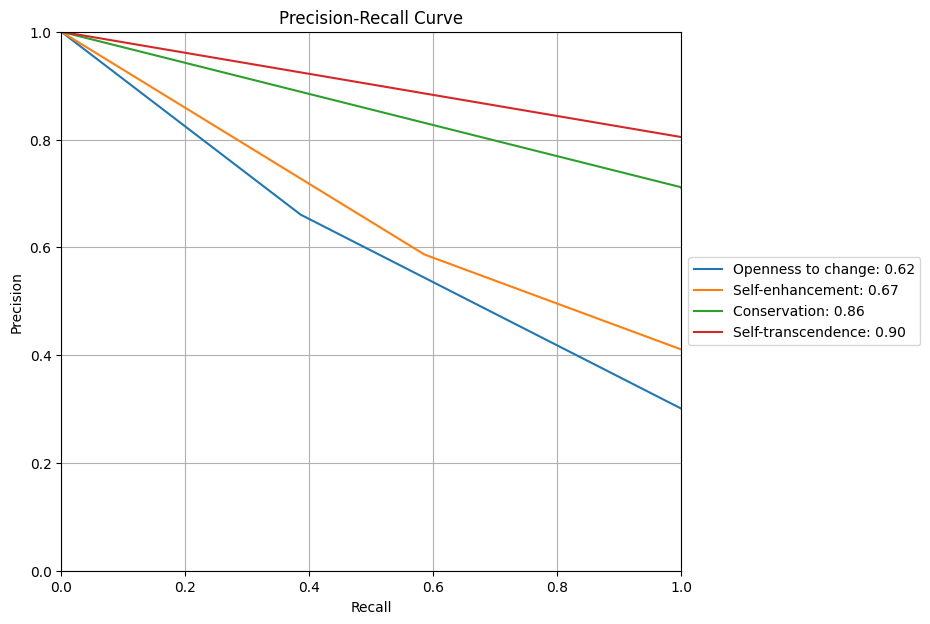

In [170]:
small_test_dataset = ArgumentDataset(df_test)

precision_curve = PrecisionRecallCurve(task="multilabel", num_labels=4).to(device)


y_pred_best = model_predict(best_model, test_dataloader)

y_true = torch.cat([data["labels"] for data in test_dataloader], dim=0)
y_true = y_true.type(torch.LongTensor).to(device)

curve = precision_curve(y_pred_best, y_true)
precision, recall, _ = curve


plt.figure(figsize=(8,7))
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

label_to_auc = {}
for i in range(len(level_3_categories)):
    label = level_3_categories[i]
    precision_cpu = precision[i].cpu()
    recall_cpu = recall[i].cpu()

    auc = -1 * torch.trapz(precision_cpu, recall_cpu)

    label_to_auc[label] = auc.item()

    plt.plot(recall_cpu, precision_cpu, label=f"{label}: {auc:.2f}")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


#### Confusion matrices

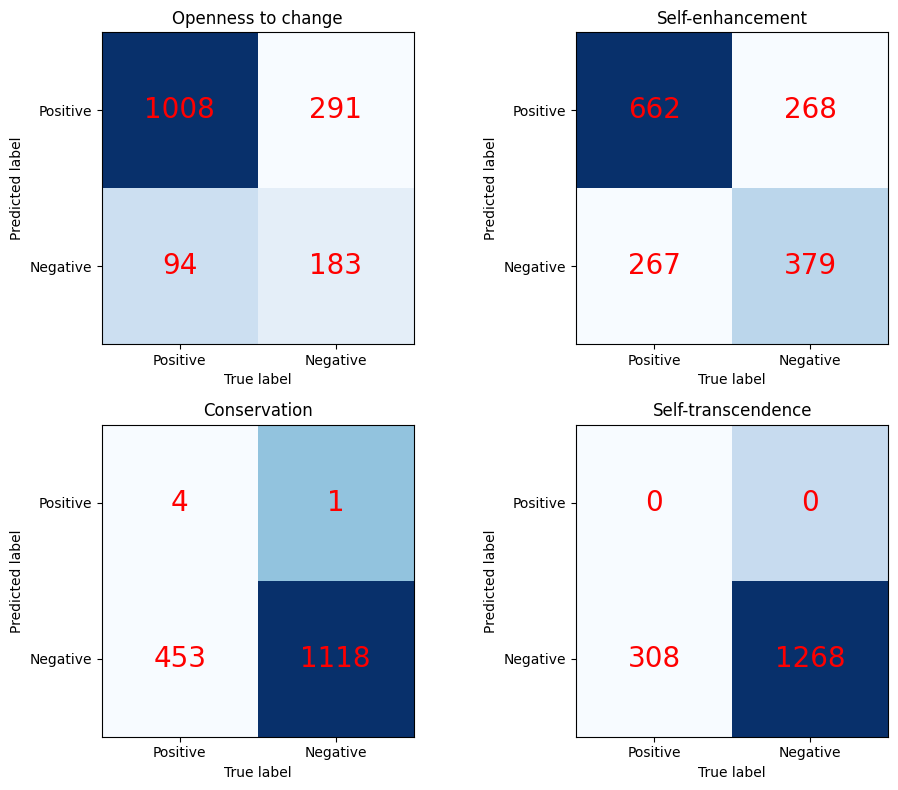

In [171]:
confusion_matrix_metric = MultilabelConfusionMatrix(num_labels=len(level_3_categories)).to(device)

confusion_matrix = confusion_matrix_metric(y_pred_best, y_true)

# Craete a subplot for each category
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()


for i, category in enumerate(level_3_categories):
    axs[i].imshow(confusion_matrix[i].cpu().numpy(), cmap="Blues")
    axs[i].set_title(category)
    axs[i].set_xlabel("True label")
    axs[i].set_ylabel("Predicted label")
    axs[i].set_xticks([0, 1])
    axs[i].set_yticks([0, 1])
    axs[i].set_xticklabels(["Positive", "Negative"])
    axs[i].set_yticklabels(["Positive", "Negative"])
    axs[i].grid(False)

    # add the values to the plot
    for k in range(2):
        for j in range(2):
            axs[i].text(k, j, confusion_matrix[i][k, j].item(), ha="center", va="center", color="Red", fontsize=20)

#
plt.tight_layout()
plt.show()

#### Model performance on most/least frequent classes

#### Specific misclassified examples

### Best model vs baselines

In [172]:
baseline_random = RandomUniformClassifier()
baseline_majority = MajorityClassifier()

baseline_majority.fit(train_dataloader)

models["Random"] = baseline_random
models["Majority"] = baseline_majority


f1_scores = {}
for model_name, model in models.items():
    print(f"Evaluating model {model_name}...")
    
    f1_score, f1_score_average = evaluate_model(model, test_dataloader)
    f1_scores[model_name] = f1_score.cpu().tolist()
    
    f1_scores[model_name] = {
        "F1 Score": f1_score.cpu().tolist(),
        "Average F1 Score": f1_score_average.cpu().tolist()
    }
    
f1_scores

tensor([False, False,  True,  True])
Evaluating model Best model...
Evaluating model bert_w_c...
Evaluating model bert_w_cp...
Evaluating model bert_w_cps...
Evaluating model Random...
Evaluating model Majority...


{'Best model': {'F1 Score': [0.487350195646286,
   0.5862335562705994,
   0.8312267661094666,
   0.8917018175125122],
  'Average F1 Score': 0.6991280317306519},
 'bert_w_c': {'F1 Score': [0.008385743945837021,
   0.4736451506614685,
   0.8304266929626465,
   0.8917018175125122],
  'Average F1 Score': 0.5510398149490356},
 'bert_w_cp': {'F1 Score': [0.5454545617103577,
   0.4837758243083954,
   0.8289920687675476,
   0.8917018175125122],
  'Average F1 Score': 0.6874810457229614},
 'bert_w_cps': {'F1 Score': [0.487350195646286,
   0.5862335562705994,
   0.8312267661094666,
   0.8917018175125122],
  'Average F1 Score': 0.6991280317306519},
 'Random': {'F1 Score': [0.4034401774406433,
   0.44242846965789795,
   0.5835962295532227,
   0.6199513673782349],
  'Average F1 Score': 0.5123540163040161},
 'Majority': {'F1 Score': [0.0, 0.0, 0.8304266929626465, 0.8917018175125122],
  'Average F1 Score': 0.4305321276187897}}

In [173]:
for model_name in f1_scores.keys():
    for i, category in enumerate(level_3_categories):
        f1_scores[model_name][category] = f1_scores[model_name]["F1 Score"][i]
    
baseline_comparison = pd.DataFrame(f1_scores).T 
baseline_comparison.drop(columns=["F1 Score"], inplace=True)
baseline_comparison

,Average F1 Score,Openness to change,Self-enhancement,Conservation,Self-transcendence
Best model,0.699128,0.48735,0.586234,0.831227,0.891702
bert_w_c,0.55104,0.008386,0.473645,0.830427,0.891702
bert_w_cp,0.687481,0.545455,0.483776,0.828992,0.891702
bert_w_cps,0.699128,0.48735,0.586234,0.831227,0.891702
Random,0.512354,0.40344,0.442428,0.583596,0.619951
Majority,0.430532,0.0,0.0,0.830427,0.891702


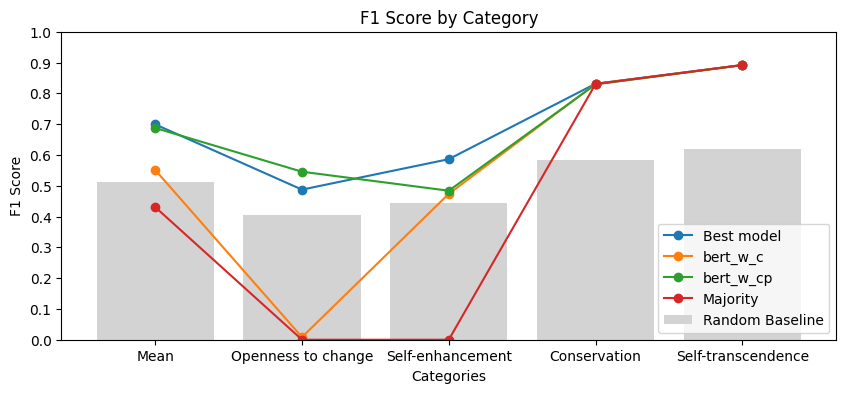

In [174]:
baseline_random = baseline_comparison.loc["Random"]


# Sample data (replace this with your actual data)
plt.figure(figsize=(10, 4))
categories = ["Mean"] + level_3_categories
# Bar chart
plt.bar(categories, baseline_random, color='lightgray', label='Random Baseline')

# Line plot
for model_name in baseline_comparison.index:
    if model_name == "Random":
        continue
        
    if model_name == best_model_name:
        continue 
        
    plt.plot(categories, baseline_comparison.loc[model_name], marker='o', linestyle='-', label=model_name)

# plt.plot(categories, f1_score_best_list + [f1_score_best_average], marker='o', linestyle='-', color='green', label='F1 Score (Line)')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.title('F1 Score by Category')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend()
plt.yticks(np.arange(0, 1.1, 0.1))

# Adding legend
plt.legend()

# Show the plot
plt.show()

### Best model vs variants

In [175]:
# Sample 5 of the worst predictions from the best model

# Get the predictions of the best model
#y_pred_best = model_predict(best_model, test_dataloader)

# Get the target from the test dataloader
y_true = torch.cat([data["labels"] for data in test_dataloader], dim=0)

# Get the indices of the worst predictions
worst_indices = torch.argsort(torch.sum(torch.abs(y_pred_best - y_true), dim=1), descending=True)[:5]

# Get the features of the worst predictions
worst_features = [test_dataset[i] for i in worst_indices.tolist()]


# put into a dataframe

worst_df = pd.DataFrame(worst_features)#.drop(columns=["labels"])
worst_df["Predicted"] = y_pred_best[worst_indices].tolist()

# Reorder the columns
worst_df = worst_df[["Premise", "Conclusion", "Stance", "labels", "Predicted"]]

# convert Stance tensor to string
worst_df["Stance"] = worst_df["Stance"].map(lambda x: x.item()).map({1: "in favor of", 0: "against"})

# Convert labels and predictions to string
worst_df["labels"] = worst_df["labels"].apply(lambda x: [level_3_categories[i] for i in range(len(x)) if x[i] == 1])
worst_df["Predicted"] = worst_df["Predicted"].apply(lambda x: [level_3_categories[i] for i in range(len(x)) if x[i] == 1])

# print it in a for loop
for _, row in worst_df.iterrows():
    print(f"Premise: {row['Premise']}")
    print(f"Conclusion: {row['Conclusion']}")
    print(f"Stance: {row['Stance']}")
    print(f"Labels: {row['labels']}")
    print(f"Predicted: {row['Predicted']}")
    print()

Premise: there is no reason to force those who are fit for combat to leave the armed forces as long as they voluntarily want to be in them
Conclusion: We should prohibit women in combat
Stance: against
Labels: ['Openness to change', 'Self-enhancement']
Predicted: ['Conservation', 'Self-transcendence']

Premise: flag burning is a peaceful and non-violent way of expressing dissatisfaction with the policies of a country.
Conclusion: We should prohibit flag burning
Stance: against
Labels: ['Openness to change', 'Self-enhancement']
Predicted: ['Conservation', 'Self-transcendence']

Premise: if women want to stand up to fight and protect our country that desire and conviction needs to continue.
Conclusion: We should prohibit women in combat
Stance: against
Labels: ['Openness to change', 'Self-enhancement']
Predicted: ['Conservation', 'Self-transcendence']

Premise: flag burning, while the majority hate it, is a simple way of protesting that is not physically hurting anyone.
Conclusion: We sh